In [ ]:
# picking the best method for choosing the optimal number of delays and delay interval
# mutual info may be the best for picking the lag, and then false neighbors for picking the embedding dimension

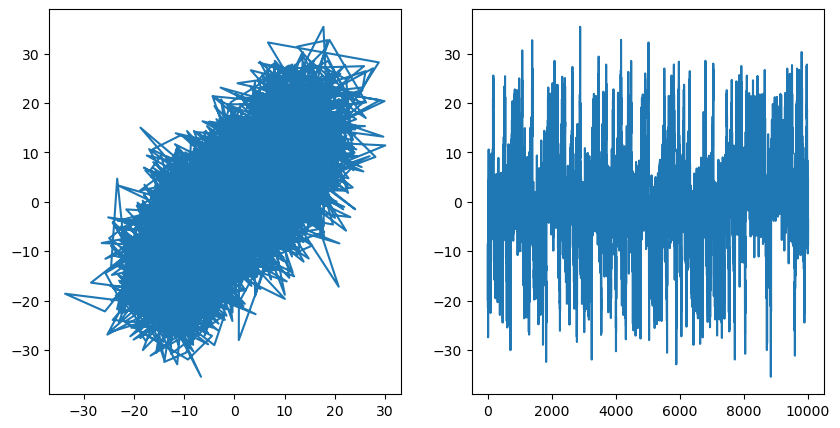

In [68]:
# simulate data
import matplotlib.pyplot as plt
import numpy as np
from utils import embed_signal_torch
import torch

from dysts.flows import Lorenz

## Load and simulate an attractor
model = Lorenz()
model.dt = 0.01
sol = model.make_trajectory(10000, resample=False, noise=0.0)

sol += np.random.normal(0, 0.1, sol.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[1].plot(sol[:, 1])

In [70]:
d = sol[:, 0]

In [54]:
from sklearn import metrics


# code from skccm
def mutual_info(X, max_lag=20):
    # number of bins - say ~ 20 pts / bin for joint distribution
    # and that at least 4 bins are required
    N = max(X.shape)
    num_bins = max(4.0, np.floor(np.sqrt(N / 20)))
    num_bins = int(num_bins)

    m_score = np.zeros((max_lag))

    for jj in range(max_lag):
        lag = jj + 1

        ts = X[0:-lag]
        ts_shift = X[lag::]

        min_ts = np.min(X)
        max_ts = np.max(X) + 0.0001  # needed to bin them up

        bins = np.linspace(min_ts, max_ts, num_bins + 1)

        bin_tracker = np.zeros_like(ts)
        bin_tracker_shift = np.zeros_like(ts_shift)
        for ii in range(num_bins):

            locs = np.logical_and(ts >= bins[ii], ts < bins[ii + 1])
            bin_tracker[locs] = ii

            locs_shift = np.logical_and(ts_shift >= bins[ii], ts_shift < bins[ii + 1])
            bin_tracker_shift[locs_shift] = ii
        m_score[jj] = metrics.mutual_info_score(bin_tracker, bin_tracker_shift)
    return m_score


# def mutual_info_new(d,max_lag=20):

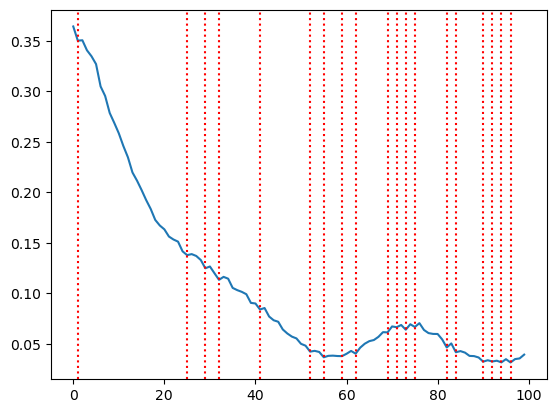

In [71]:
mi = mutual_info(d, max_lag=100)
plt.plot(mi)
# identify local mins
from scipy.signal import find_peaks

peaks, _ = find_peaks(-mi)
for p in peaks:
    plt.axvline(p, color="r", linestyle=":")
# mi

In [72]:
d.shape

(10000,)

In [57]:
# derived from the matlab code:
# https://physics.emory.edu/faculty/weeks/research/tseries3.html#lorenz
# https://github.com/gyrheart/FNN/blob/master/Henon%20map/f_fnn.m
def delay_embed(x, m, tau, npoint=None):
    """
    Phase space reconstruction using time-delay embedding.
    :param x: time series
    :param m: embedding dimension
    :param tao: time delay
    :param npoint: total number of reconstructed vectors (optional)
    :return: reconstructed phase space matrix Y (M x m)
    """
    N = x.shape[0]
    if npoint is None:
        M = N - (m - 1) * tau
    else:
        M = npoint

    Y = np.zeros((M, m))
    for i in range(m):
        Y[:, i] = x[(np.arange(M) + i * tau)]

    return Y


def false_nearest_neighbors(x, tau, mmax, rtol=15, atol=2):
    """
    Calculate the percentage of false nearest neighbors for each embedding dimension.
    :param x: time series (1d)
    :param tao: time delay
    :param mmax: maximum embedding dimension
    :param rtol: ratio threshold
    :param atol: absolute threshold
    :return: percentage of false nearest neighbors per embedding dimension
    """
    N = x.shape[0]
    Ra = np.std(x, ddof=1)  # unbiased estimator

    fnn = np.zeros(mmax)

    for m in range(1, mmax + 1):
        M = N - m * tau
        Y = delay_embed(x, m, tau, M)
        fnn_count = 0

        print(m)
        for n in range(M):

            y0 = np.tile(
                Y[n, :], (M, 1)
            )  # distance form this point to all other points
            distance = np.sqrt(np.sum((Y - y0) ** 2, axis=1))
            sorted_indices = np.argsort(distance)
            nearest_pos = sorted_indices[1]  # nearest neighbor index
            # D = np.square(Y[n+m*tau,:-1] - Y[nearest_pos,:-1]) #distance in the embedded space of previous dimension
            # print(D.shape)
            # todo: explain this
            # compare the distance between the point and its nearest neighbor in the original space
            D = np.abs(x[n + m * tau] - x[nearest_pos + m * tau])
            R = np.sqrt(D**2 + distance[nearest_pos] ** 2)

            if D / distance[nearest_pos] > rtol or R / Ra > atol:
                fnn_count += 1

        fnn[m - 1] = fnn_count / M * 100

    return fnn

In [75]:
# d = np.random.uniform(-1,1,size=(1000))

In [76]:
fnn = false_nearest_neighbors(d, 1, 10)

1
2
3
4
5
6
7
8
9
10


array([98.1981982 , 57.21442886, 22.96890672, 19.97991968, 21.30653266,
       21.32796781, 26.28398792, 29.83870968, 41.06962664, 59.8989899 ])

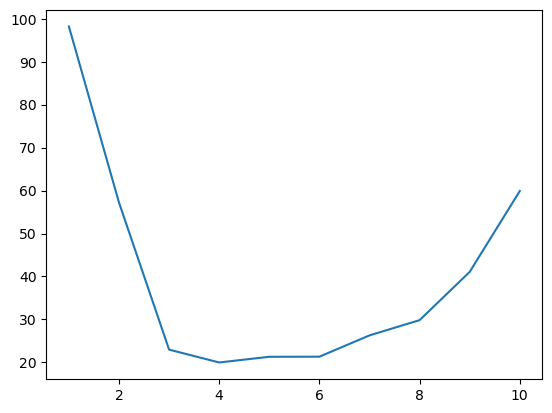

In [77]:
plt.plot(np.arange(1, len(fnn) + 1), fnn)
fnn

In [65]:
m = np.argmin(fnn) + 1
m

5

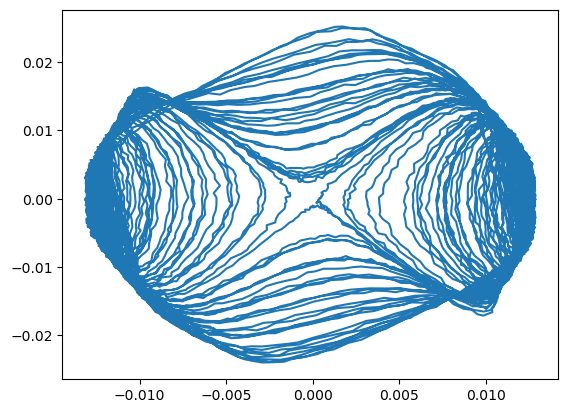

In [61]:
n_delays = m
delay_interval = peaks[0]


H = embed_signal_torch(sol[:, 0:1], n_delays, delay_interval)

U, S, V = torch.svd(H.T)

V = V.cpu().numpy()
plt.plot(V[:, 0], V[:, 1])

In [ ]:
from utils import embed_signal_torch
from sklearn.metrics import pairwise_distances
import torch
from copy import deepcopy


def false_neighbors(data, tau, max_delay, rtol=1e-3, atol=1e-10):  # this is too slow
    data = data[:, None]
    fnn = np.zeros(max_delay)
    rel_std = np.std(data)
    old_h = embed_signal_torch(data, 1, tau)
    old_pdists = pairwise_distances(old_h)
    for nd in range(2, max_delay + 1):
        print(nd)
        h = embed_signal_torch(data, nd, tau)
        pdists = pairwise_distances(h)

        # compute the fraction of false neighbors
        ratios = pdists / old_pdists
        n_false = np.sum(np.abs(ratios - 1) > rtol)
        n_false += np.sum(np.abs(pdists - rel_std) > atol)

        fnn[nd - 1] = n_false / h.shape[0]
        old_h = deepcopy(h)
        old_pdists = deepcopy(pdists)
        print(fnn[nd - 1])

    return fnn


fnn = false_neighbors(d[:100], tau=peaks[0], max_delay=100)